In [1]:
import lattice_cpu as cpu
import lattice_gpu_naive as gpu_naiv
import lattice_gpu_opt as gpu_opt
%matplotlib inline

In this lab, we're asked to parallelize the Lattice Boltzmann algorithm on CUDA-capable GPUs.

The LBM algorithm we're looking at is seperated in a bunch of independent successive steps that are operating on different 3D-tensors:
- Simulation environment initialization
- In/Outflow conditions setup
- Rho-value computing
- Macroscopic (Velocity/Density) values computing
- New equilibrium state computing
- Collision
- Obstacle propagation bouncing-back
- **Streaming**

As the code in `lattice_cpu.py` and `lattice_gpu_naive.py` shows, these steps operate on each voxel of the input tensors seperately, which means, for our parallelization process, we may consider all of the steps as cell-local operations. This is perfect for our goal as we're going to be able to map the matrix on the GPU-memory in its exact 3D form (supporting memory coalescence for the multithreaded-access) and then define our operations as CUDA kernels that would run on each of our voxels independently. And this is exactly what was done on the `lattice_gpu_naive.py` version of the parallel code.

Downward is the benchmarking and comparison of different runs of the CPU and the naive GPU code written to analyze the gain obtained by this parallelization procedure:

2.63 s ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
310 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


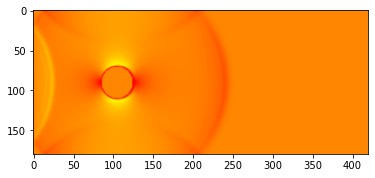

In [8]:
%timeit cpu.main(200, 10, notebook=True)
%timeit gpu_naiv.main(200, 10, notebook=True)

27.2 s ± 837 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.05 s ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


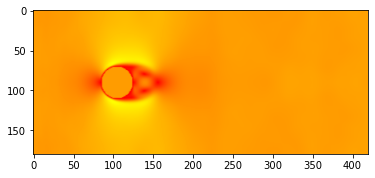

In [9]:
%timeit cpu.main(2000, 100, notebook=True)
%timeit gpu_naiv.main(2000, 100, notebook=True)

4min 28s ± 6.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
31.4 s ± 1.58 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


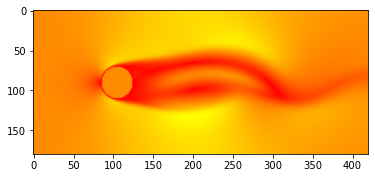

In [5]:
%timeit cpu.main(20000, 1000, notebook=True)
%timeit gpu_naiv.main(20000, 1000, notebook=True)

As we can see in the 3 benchmarks we've done on different numbers of iterations, we're constantly obtaining an acceleration ratio of **10x**. This is due to the different calls from global memory.

But when going through a deeper dive into the algorithm, we notice that we can eliminate the calls of `feq`, `vel` & `rho` matrices from the GPU's global memory as all of the operations on these matrices are cell-wise independent, which means we can compute their values and store them on the local memory of each of the kernels.

To do so, we're going to combine all of the LBM algorithm steps into only one step that would run for each iteration of the solver loop. The only problem is that in the **streaming step**, each thread needs some values of other threads, which means that we need to **synchronise all of the GPU threads before starting the streaming step**. To do this, either we proceed by synchronising all the current execution context (using `numba.cuda.synchronise` function) or we may just seperate the stream step into its own function as by doing so, the synchronisation is automatically done and we'd wait for the before-step to be executed before running into the streaming step.

After this being done, we eliminated the throttling caused to the GPU efficiency (~60%) while running our code and maximize by then its throughput as each thread has to do less global-memory fetching now.

By this, we obtain a more optimized version (coded in the `lattice_gpu_opt.py` file) benchmarked below:

141 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.34 s ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.8 s ± 77.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


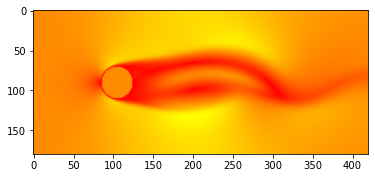

In [2]:
%timeit gpu_opt.main(200, 10, notebook=True)
%timeit gpu_opt.main(2000, 100, notebook=True)
%timeit gpu_opt.main(20000, 1000, notebook=True)

As we can see after these 3 tests, all three *optimized* runtimes represent an acceleration factor of **3x** compared to the naively-parallelized version. Which translates to a whopping **30x** acceleration compared to the sequential cpu-bounded version.